# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [2]:
size = 1024
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 300

max_velocity = 2.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 6.61 s, sys: 14.9 s, total: 21.5 s
Wall time: 21.5 s


In [3]:
# JAX-CFD uses GridVariable objects for input/output. These objects contain:
#  - array data
#  - an "offset" that documents the position on the unit-cell where the data
#    values are located
#  - grid properties
#  - boundary conditions on the variable
with np.printoptions(edgeitems=1):
  for i, u in enumerate(trajectory):
    print(f'Component {i}: {u}')

Component 0: GridVariable(array=GridArray(data=array([[[-1.1916747 , ..., -1.1937752 ],
        ...,
        [-1.1869801 , ..., -1.1892308 ]],

       ...,

       [[-0.8932126 , ..., -0.88934493],
        ...,
        [-0.89072657, ..., -0.8867341 ]]], dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(1024, 1024), step=(0.006135923151542565, 0.006135923151542565), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0))))
Component 1: GridVariable(array=GridArray(data=array([[[-0.36850122, ..., -0.37319592],
        ...,
        [-0.35963228, ..., -0.36429253]],

       ...,

       [[ 0.69612396, ...,  0.6936379 ],
        ...,
        [ 0.703853  , ...,  0.701265  ]]], dtype=float32), offset=(0.5, 1.0), grid=Grid(shape=(1024, 1024), step=(0.006135923151542565, 0.006135923151542565), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=H

In [4]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

In [5]:
ds

<xarray.Dataset>
Dimensions:  (time: 300, x: 1024, y: 1024)
Coordinates:
  * x        (x) float32 0.003068 0.009204 0.01534 0.02148 ... 6.268 6.274 6.28
  * y        (y) float32 0.003068 0.009204 0.01534 0.02148 ... 6.268 6.274 6.28
  * time     (time) float64 0.0 0.03835 0.0767 0.115 ... 11.35 11.39 11.43 11.47
Data variables:
    u        (time, x, y) float32 -1.192 -1.189 -1.186 ... -0.8826 -0.8867
    v        (time, x, y) float32 -0.3685 -0.3637 -0.3587 ... 0.6986 0.7013

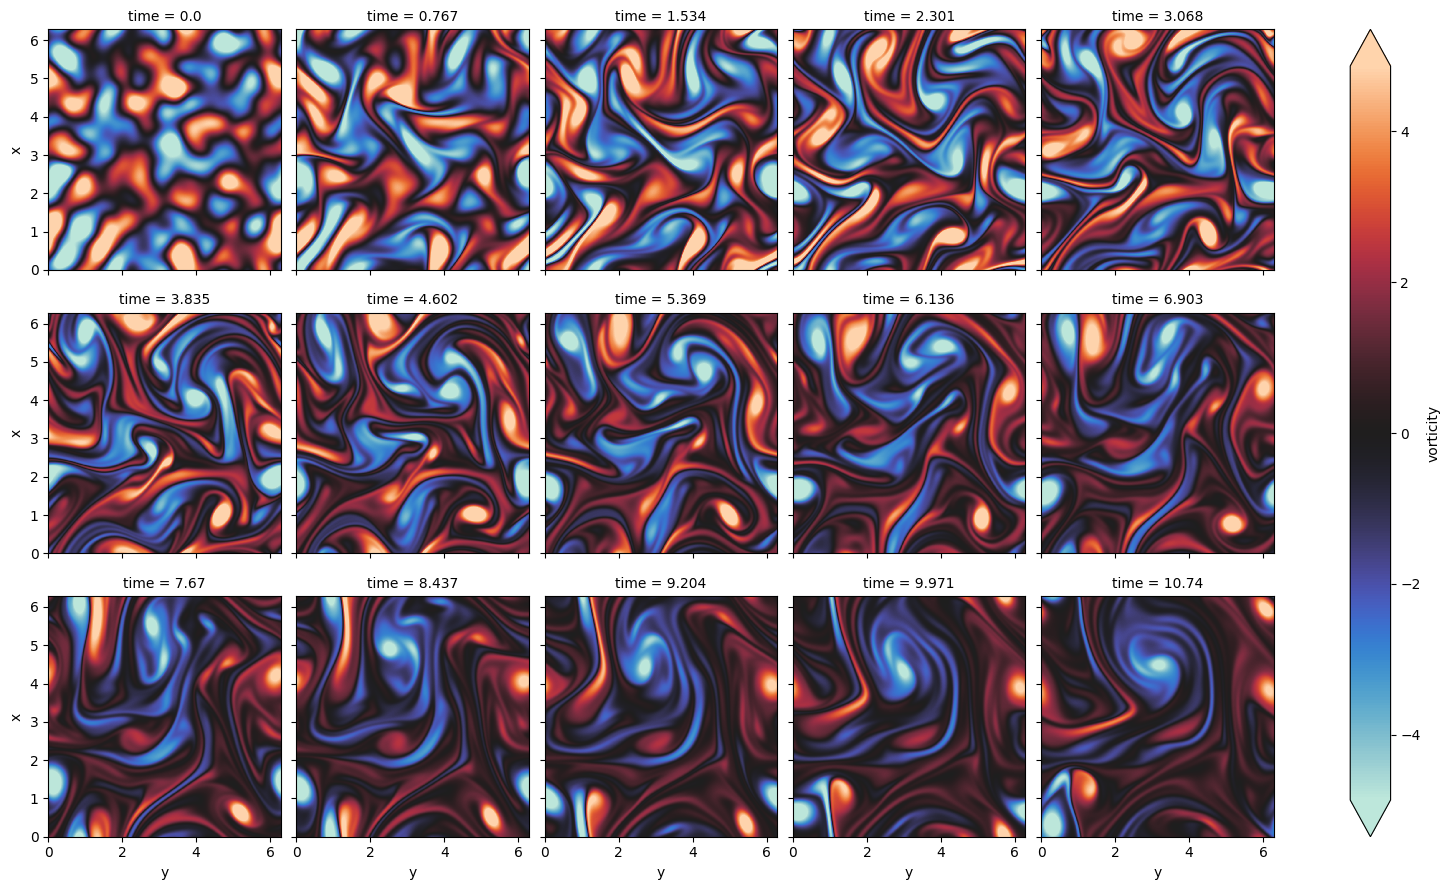

In [6]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));